In [1]:
from os import listdir
from os.path import isfile, isdir, join

In [4]:
!ls /data/

__MACOSX				     PlantCLEF2016Test
PlantCLEF2015TestDataWithAnnotations	     PlantCLEF2016Test.tar.gz
PlantCLEF2015TestDataWithAnnotations.tar.gz  RunFilesToolAndResults
PlantCLEF2015TrainingData		     RunFilesToolAndResults.zip
PlantCLEF2015TrainingData.tar.gz


In [5]:
train_path = "/data/PlantCLEF2015TrainingData/train"

files = {
    f.split(".")[0]: {
        "image": join(train_path, f),
        "xml": join(train_path, f.split(".")[0]+".xml")
    } 
    for f in listdir(train_path)
    if f[0] != "." and f[-3:] == "jpg"
}

print(len(files))

91758


In [6]:
import xml.etree.ElementTree as ET
from tqdm import tqdm


for f in tqdm(files):
    xml = files[f]['xml']
    tree = ET.parse(xml)
    root = tree.getroot()
    data = {}
    for child in root:
        data[child.tag] = child.text
    files[f]['data'] = data

100%|██████████| 91758/91758 [00:15<00:00, 5773.30it/s]


In [7]:
from pprint import pprint

pprint(files['9733'])

{'data': {'Author': 'daniel barthelemy',
          'ClassId': '4736',
          'Content': 'Leaf',
          'Date': '2013-11-3',
          'Family': 'Rosaceae',
          'Genus': 'Cydonia',
          'ImageId2014': '36922',
          'Latitude': '43.13079',
          'LearnTag': 'Train',
          'Location': 'Toulon',
          'Longitude': '5.9022',
          'MediaId': '9733',
          'ObservationId': '13689',
          'ObservationId2014': '7746',
          'Species': 'Cydonia oblonga Mill.',
          'Vote': '4',
          'YearInCLEF': 'PlantCLEF2014'},
 'image': '/data/PlantCLEF2015TrainingData/train/9733.jpg',
 'xml': '/data/PlantCLEF2015TrainingData/train/9733.xml'}


In [8]:
import json

with open("plant_clef_data.json", "w") as F:
    json.dump(files, F)

# Import Data to TensorFlow

In [9]:
import tensorflow as tf
import tensorflow_addons as tfa

In [10]:
img_files = []
labels    = []

for f in files:
    img_files.append(files[f]['image'])
    labels.append(files[f]['data']['Content'])
    
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 64

Map = {}
count = 0
Labels = []

for label in labels:
    if not Map.get(label):
        Map[label] = count
        count += 1
    Labels.append(Map[label])
    

In [11]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [12]:
def process_path(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

In [13]:
list_ds = tf.data.Dataset.from_tensor_slices(img_files)

In [14]:
image_ds = list_ds.map(process_path)

In [15]:
label_ds = tf.data.Dataset.from_tensor_slices(Labels)

In [16]:
train_ds = tf.data.Dataset.zip((image_ds, label_ds))

train_ds = train_ds.shuffle(1024).batch(BATCH_SIZE)

# Model Creation

In [17]:
model = tf.keras.Sequential()

model.add(tf.keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)))

model.add(tf.keras.layers.Conv2D(
    64, 
    (2,2), 
    strides=2,
    activation='relu',
    padding='same'
))

model.add(tf.keras.layers.Conv2D(
    64, 
    (2,2), 
    strides=3,
    activation='relu',
    padding='same'
))

model.add(tf.keras.layers.Conv2D(
    64, 
    (2,2), 
    strides=2,
    activation='relu',
    padding='same'
))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation=None))

model.add(tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 64)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        16448     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        16448     
_________________________________________________________________
flatten (Flatten)            (None, 10816)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               2769152   
_________________________________________________________________
lambda (Lambda)              (None, 256)               0         
Total params: 2,802,880
Trainable params: 2,802,880
Non-trainable params: 0
______________________________________________

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tfa.losses.TripletSemiHardLoss())

In [20]:
# Train the network
history = model.fit(
    train_ds,
    epochs=20)

Epoch 1/20
1434/1434 [==============================] - 504s 351ms/step - loss: 0.8586
Epoch 2/20
1434/1434 [==============================] - 497s 347ms/step - loss: 0.8100
Epoch 3/20
1434/1434 [==============================] - 496s 346ms/step - loss: 0.7935
Epoch 4/20
1434/1434 [==============================] - 495s 345ms/step - loss: 0.7785
Epoch 5/20
1434/1434 [==============================] - 496s 346ms/step - loss: 0.7665
Epoch 6/20
1434/1434 [==============================] - 498s 347ms/step - loss: 0.7504
Epoch 7/20
1434/1434 [==============================] - 500s 349ms/step - loss: 0.7362
Epoch 8/20
1434/1434 [==============================] - 501s 350ms/step - loss: 0.7212
Epoch 9/20
1434/1434 [==============================] - 501s 349ms/step - loss: 0.7096
Epoch 10/20
1434/1434 [==============================] - 501s 349ms/step - loss: 0.6953
Epoch 11/20
1434/1434 [==============================] - 502s 350ms/step - loss: 0.6854
Epoch 12/20
1434/1434 [==================

In [21]:
model.save("plant_images.tf", save_format="tf")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: plant_images.tf/assets


In [22]:
# Train the network
history = model.fit(
    train_ds,
    epochs=10)

Epoch 1/10
1434/1434 [==============================] - 501s 349ms/step - loss: 0.5779
Epoch 2/10
1434/1434 [==============================] - 501s 349ms/step - loss: 0.5684
Epoch 3/10
1434/1434 [==============================] - 502s 350ms/step - loss: 0.5567
Epoch 4/10
1434/1434 [==============================] - 502s 350ms/step - loss: 0.5512
Epoch 5/10
1434/1434 [==============================] - 504s 351ms/step - loss: 0.5401
Epoch 6/10
1434/1434 [==============================] - 505s 352ms/step - loss: 0.5360
Epoch 7/10
1434/1434 [==============================] - 504s 352ms/step - loss: 0.5291
Epoch 8/10
1434/1434 [==============================] - 504s 351ms/step - loss: 0.5221
Epoch 9/10
1434/1434 [==============================] - 506s 353ms/step - loss: 0.5159
Epoch 10/10
1434/1434 [==============================] - 504s 351ms/step - loss: 0.5097


In [23]:
model.save("plant_images_v2.tf", save_format="tf")

INFO:tensorflow:Assets written to: plant_images_v2.tf/assets


/opt/conda/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../opt/conda/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/opt/conda/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../opt/conda/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parall

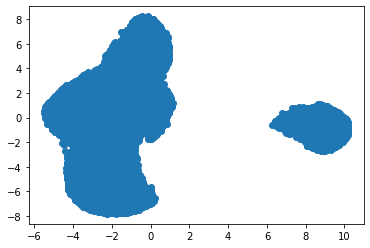

In [24]:
import umap
import matplotlib.pyplot as plt

results = model.predict(train_ds)

reducer = umap.UMAP()
embedding = reducer.fit_transform(results)
plt.scatter(embedding[:,0], embedding[:,1])

In [30]:
batch = train_ds.take(1)

In [38]:
IMGS, LABS = [], []

for b in batch:
    imgs, labs = b[0], b[1]
    IMGS.extend(imgs)
    LABS.extend(labs)
    
print(IMGS)

[<tf.Tensor: id=91594, shape=(150, 150, 3), dtype=float32, numpy=
array([[[0.43675384, 0.4350022 , 0.3123486 ],
        [0.4374641 , 0.4609935 , 0.30020916],
        [0.42853597, 0.48213074, 0.2827843 ],
        ...,
        [0.49648145, 0.4415795 , 0.30432457],
        [0.47450984, 0.4156863 , 0.29128104],
        [0.45772538, 0.406745  , 0.27341163]],

       [[0.41743794, 0.43985623, 0.30707845],
        [0.44150984, 0.47547063, 0.30425492],
        [0.4347386 , 0.5064968 , 0.28832027],
        ...,
        [0.4902091 , 0.4392287 , 0.30589536],
        [0.47450984, 0.41960788, 0.29607844],
        [0.46406525, 0.40524173, 0.27582994]],

       [[0.41372553, 0.4529412 , 0.3156863 ],
        [0.4337909 , 0.48235297, 0.3070915 ],
        [0.44098043, 0.51549023, 0.29588237],
        ...,
        [0.46541402, 0.41443363, 0.2889434 ],
        [0.46395427, 0.41297388, 0.28748366],
        [0.47947764, 0.41673255, 0.28732076]],

       ...,

       [[0.23418313, 0.22241843, 0.1871243 ],
  

In [39]:
res = model.predict([IMGS])

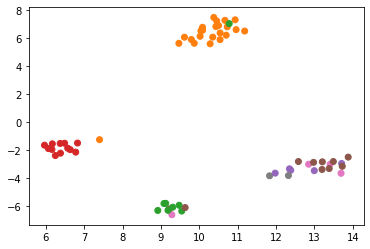

In [40]:
import seaborn as sns

res = model.predict([IMGS])
embedding = reducer.fit_transform(res)
plt.scatter(embedding[:,0], embedding[:,1], c=[sns.color_palette()[x] for x in LABS])

In [41]:
# Train the network
history = model.fit(
    train_ds,
    epochs=50
)

model.save("plant_images_v3.tf", save_format="tf")

Epoch 1/50
1434/1434 [==============================] - 488s 340ms/step - loss: 0.5040
Epoch 2/50
1434/1434 [==============================] - 489s 341ms/step - loss: 0.4985
Epoch 3/50
1434/1434 [==============================] - 486s 339ms/step - loss: 0.4904
Epoch 4/50
1434/1434 [==============================] - 487s 339ms/step - loss: 0.4824
Epoch 5/50
1434/1434 [==============================] - 489s 341ms/step - loss: 0.4781
Epoch 6/50
1434/1434 [==============================] - 486s 339ms/step - loss: 0.4779s - loss
Epoch 7/50
1434/1434 [==============================] - 483s 337ms/step - loss: 0.4704
Epoch 8/50
1434/1434 [==============================] - 482s 336ms/step - loss: 0.4668
Epoch 9/50
1434/1434 [==============================] - 482s 336ms/step - loss: 0.4597
Epoch 10/50
1434/1434 [==============================] - 480s 335ms/step - loss: 0.4579
Epoch 11/50
1434/1434 [==============================] - 480s 335ms/step - loss: 0.4537
Epoch 12/50
1434/1434 [==========

In [42]:
res = model.predict([IMGS])

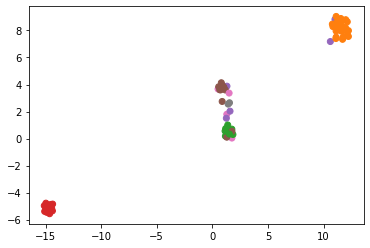

In [43]:
embedding = reducer.fit_transform(res)
plt.scatter(embedding[:,0], embedding[:,1], c=[sns.color_palette()[x] for x in LABS])

In [47]:
Map
Pam = {
    3: 'LeafScan',
    1: 'Flower',
    2: 'Entire',
    4: 'Fruit',
    5: 'Leaf',
    6: 'Branch',
    7: 'Stem'
}

In [57]:
C = {}
colors = [(x, sns.color_palette()[x]) for x in LABS]
for i in range(1,8):
    for idx, color in colors:
        if i == idx:
            print(idx.numpy())
            C[idx.numpy()] = color
            break

1
2
3
4
5
6
7


In [58]:
C

{1: (1.0, 0.4980392156862745, 0.054901960784313725),
 2: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 3: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 4: (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 5: (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 6: (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 7: (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)}

In [60]:
type(res)

numpy.ndarray

In [85]:
import numpy as np

to_show = []
for idx, color in colors:
    if idx.numpy() in [2, 4, 6]:
        to_show.append(idx.numpy())

In [88]:
_LABS = np.array(LABS)
print(_LABS)

[1 3 1 2 7 1 1 6 4 1 6 1 6 5 4 3 2 4 1 1 4 3 2 5 1 1 4 1 1 1 5 1 2 1 1 1 2
 1 5 3 3 3 5 5 1 1 2 1 5 3 6 5 3 1 5 3 5 2 3 7 1 3 3 2]


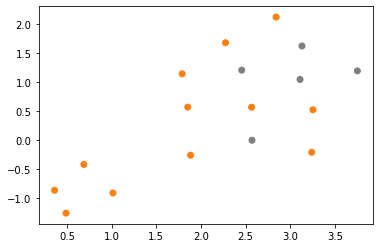

In [87]:
embedding = reducer.fit_transform(res[to_show])
plt.scatter(embedding[:,0], embedding[:,1], c=[sns.color_palette()[x] for x in _LABS[to_show]])